# Imports

In [45]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from data_utils.datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier, TemporalConvRNN, Seq2SeqRNN
import data_utils.augmentations as augs
import csv

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [38]:
data_filename = os.path.expanduser('~/data/pt_decoding_data_S62.pkl')
# data_filename = ('../data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [39]:
pt = 'S14'
p_ind = 1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(144, 200, 111), (144,), (144, 3)]
[[(148, 200, 111), (148,), (148, 3)], [(151, 200, 63), (151,), (151, 3)], [(46, 200, 149), (46,), (46, 3)], [(151, 200, 74), (151,), (151, 3)], [(137, 200, 144), (137,), (137, 3)], [(141, 200, 171), (141,), (141, 3)], [(178, 200, 201), (178,), (178, 3)]]


In [40]:
fold_data_path = os.path.expanduser('~/workspace/transformer_data')
# fold_data_path = '.'

fs = 200 # Hz
# augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
augmentations = [augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long().unsqueeze(1) - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
# pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long().unsqueeze(1) - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[2]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]  # for seq2seq RNN
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

# create the data module
batch_size = 5000
n_folds = 20
val_size = 0.1

context_prefix = 'ptSpecific'
# dm = SimpleMicroDataModule(data, labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))
## modification of labels for seq2seq RNN ###
dm = SimpleMicroDataModule(data, align_labels, batch_size=batch_size, folds=n_folds,
                           val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))

# context_prefix = 'pooled'
# # dm = AlignedMicroDataModule(data, labels, align_labels, pool_data, AlignCCA,
# #                             batch_size=batch_size, folds=n_folds, val_size=val_size,
# #                             augmentations=augmentations, data_path=fold_data_path)
# dm = AlignedMicroDataModule(data, align_labels, align_labels, pool_data, AlignCCA,
#                             batch_size=batch_size, folds=n_folds, val_size=val_size,
#                             augmentations=augmentations, data_path=fold_data_path)
# dm.setup()

In [41]:
dm.train_dataloader().dataset.tensors[1].shape

torch.Size([122, 3])

# Define model

In [42]:
from pytorch_lightning.utilities.model_summary import summarize


gclip_val = 0.5

##### CNN TRANSFORMER #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# d_model = 128
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_head = 8
# num_layers = 2
# dim_fc = 64
# # dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# tform_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate)


##### Temporal CNN classifier #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
#                            cnn_dropout, learning_rate, l2_reg)


##### Temporal CNN GRU #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# n_filters = 100
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_layers = 1
# hidden_size = 500
# dim_fc = [128, 64]
# cnn_dropout = 0.3
# rnn_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# activ = True

# sum_model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
#                             kernel_size, dim_fc, stride, padding, cnn_dropout,
#                             rnn_dropout, learning_rate, l2_reg)



##### Seq2Seq RNN #####
# model parameters
in_channels = data.shape[-1]
num_classes = 9
n_filters = 100
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 50  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_enc_layers = 2
n_dec_layers = 1
hidden_size = 500
cnn_dropout = 0.3
rnn_dropout = 0.3
learning_rate = 1e-4
l2_reg = 1e-5
activ = False

sum_model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers, n_dec_layers, kernel_size, stride, padding, cnn_dropout, rnn_dropout, learning_rate, l2_reg)

print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | train
1 | temporal_conv | TemporalConv     | 111 K  | train
2 | encoder       | EncoderRNN       | 6.3 M  | train
3 | decoder       | DecoderRNN       | 1.5 M  | train
-----------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.743    Total estimated model params size (MB)


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Train model

In [43]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [44]:
# instantiate the trainer
max_epochs = 500
# es_pat = max_steps // 20
# max_steps = 500
es_pat = 50
warmup = 100
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [16]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [17]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [47]:
# train the model
n_iters = 20
iter_accs = []
for i in range(n_iters):
    print(f'##### Setting up data module for iteration {i+1} #####')
    dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        # if fold > 1:
        #     break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        # model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
        #                            cnn_dropout, learning_rate, l2_reg, activation=activ)
        # model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                                # kernel_size, dim_fc, stride, padding, cnn_dropout,
                                # rnn_dropout, learning_rate, l2_reg, activation=activ,
                                # decay_iters=max_epochs)
        model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                           n_dec_layers, kernel_size, stride, padding, cnn_dropout, rnn_dropout,
                           learning_rate, l2_reg, activation=activ, decay_iters=max_epochs)
        
        # model.current_fold = fold
        callbacks = [
            # ModelCheckpoint(monitor='val_loss', mode='min'),
            ModelCheckpoint(monitor='val_acc', mode='max'),
            # EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            max_epochs=max_epochs,
                            # max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print(trainer.callback_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    with open(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs_iter{i+1}.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(iter_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)
with open(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerows(iter_accs)
np.save(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.npy'), np.array(iter_accs))

##### Setting up data module for iteration 1 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.8153), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1742/checkpoints/epoch=135-step=136.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            3.178903818130493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1743/checkpoints/epoch=272-step=273.ckpt


{'train_loss': tensor(0.0135), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.3740), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1743/checkpoints/epoch=272-step=273.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           3.8226025104522705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1744/checkpoints/epoch=224-step=225.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.3554), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1744/checkpoints/epoch=224-step=225.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           3.7455835342407227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1745/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.1299), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1745/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5416666865348816
        test_loss           1.8724607229232788
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1746/checkpoints/epoch=90-step=91.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.0441), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1746/checkpoints/epoch=90-step=91.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.464181661605835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1747/checkpoints/epoch=91-step=92.ckpt


{'train_loss': tensor(0.0149), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.8189), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1747/checkpoints/epoch=91-step=92.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.7432628870010376
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1748/checkpoints/epoch=79-step=80.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.2325), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1748/checkpoints/epoch=79-step=80.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           2.0337257385253906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1749/checkpoints/epoch=122-step=123.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.4420), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1749/checkpoints/epoch=122-step=123.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.1964471340179443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1750/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0175), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.9803), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1750/checkpoints/epoch=78-step=79.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.8453222513198853
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1751/checkpoints/epoch=203-step=204.ckpt


{'train_loss': tensor(0.0136), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.5997), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1751/checkpoints/epoch=203-step=204.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           1.1491949558258057
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1752/checkpoints/epoch=62-step=63.ckpt


{'train_loss': tensor(0.0170), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.9365), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1752/checkpoints/epoch=62-step=63.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.7322015762329102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1753/checkpoints/epoch=387-step=388.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.8094), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1753/checkpoints/epoch=387-step=388.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            4.787288665771484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1754/checkpoints/epoch=67-step=68.ckpt


{'train_loss': tensor(0.0115), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.4177), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1754/checkpoints/epoch=67-step=68.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.4251656532287598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1755/checkpoints/epoch=171-step=172.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.9503), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1755/checkpoints/epoch=171-step=172.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.8713600635528564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1756/checkpoints/epoch=117-step=118.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.3278), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1756/checkpoints/epoch=117-step=118.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss           1.5455100536346436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1757/checkpoints/epoch=46-step=47.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.8673), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1757/checkpoints/epoch=46-step=47.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            1.918429970741272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1758/checkpoints/epoch=94-step=95.ckpt


{'train_loss': tensor(0.0131), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.6932), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1758/checkpoints/epoch=94-step=95.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            1.904515027999878
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1759/checkpoints/epoch=75-step=76.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6781), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1759/checkpoints/epoch=75-step=76.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.1235079765319824
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1760/checkpoints/epoch=79-step=80.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.1156), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1760/checkpoints/epoch=79-step=80.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.7818057537078857
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1761/checkpoints/epoch=56-step=57.ckpt


{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.0179), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1761/checkpoints/epoch=56-step=57.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.8401169776916504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38511908
##### Setting up data module for iteration 2 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0176), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.7558), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1762/checkpoints/epoch=71-step=72.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss            2.615464925765991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1763/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6857), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1763/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss            1.786680817604065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1764/checkpoints/epoch=169-step=170.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.9764), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1764/checkpoints/epoch=169-step=170.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss            2.759258508682251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1765/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0176), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.6433), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1765/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1666666716337204
        test_loss            2.657576322555542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1766/checkpoints/epoch=74-step=75.ckpt


{'train_loss': tensor(0.0144), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.0692), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1766/checkpoints/epoch=74-step=75.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.903550386428833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1767/checkpoints/epoch=43-step=44.ckpt


{'train_loss': tensor(0.0153), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.6094), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1767/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.4423047304153442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1768/checkpoints/epoch=124-step=125.ckpt


{'train_loss': tensor(0.0224), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.8626), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1768/checkpoints/epoch=124-step=125.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.8063137531280518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1769/checkpoints/epoch=158-step=159.ckpt


{'train_loss': tensor(0.0170), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.3350), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1769/checkpoints/epoch=158-step=159.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.119117021560669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1770/checkpoints/epoch=269-step=270.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.6594), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1770/checkpoints/epoch=269-step=270.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           3.1087028980255127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1771/checkpoints/epoch=175-step=176.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.7889), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1771/checkpoints/epoch=175-step=176.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.354457378387451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1772/checkpoints/epoch=198-step=199.ckpt


{'train_loss': tensor(0.0212), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.1830), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1772/checkpoints/epoch=198-step=199.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.6583704948425293
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1773/checkpoints/epoch=353-step=354.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.8046), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1773/checkpoints/epoch=353-step=354.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.4182910919189453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1774/checkpoints/epoch=68-step=69.ckpt


{'train_loss': tensor(0.0185), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.0123), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1774/checkpoints/epoch=68-step=69.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.15341055393219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1775/checkpoints/epoch=34-step=35.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.2642), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1775/checkpoints/epoch=34-step=35.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.2311863899230957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1776/checkpoints/epoch=190-step=191.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.1424), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1776/checkpoints/epoch=190-step=191.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.293682336807251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1777/checkpoints/epoch=53-step=54.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.8268), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1777/checkpoints/epoch=53-step=54.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            1.698227882385254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1778/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0178), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.5235), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1778/checkpoints/epoch=69-step=70.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            1.782378077507019
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1779/checkpoints/epoch=103-step=104.ckpt


{'train_loss': tensor(0.0117), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.3936), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1779/checkpoints/epoch=103-step=104.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.882542133331299
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1780/checkpoints/epoch=103-step=104.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.6352), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1780/checkpoints/epoch=103-step=104.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           1.0528504848480225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1781/checkpoints/epoch=83-step=84.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.5338), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1781/checkpoints/epoch=83-step=84.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.630768299102783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38214287
##### Setting up data module for iteration 3 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.1348), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1782/checkpoints/epoch=263-step=264.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss            3.982246160507202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1783/checkpoints/epoch=82-step=83.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.5721), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1783/checkpoints/epoch=82-step=83.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5833333134651184
        test_loss           1.8440135717391968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1784/checkpoints/epoch=230-step=231.ckpt


{'train_loss': tensor(0.0144), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.5988), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1784/checkpoints/epoch=230-step=231.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.625
        test_loss            2.033609390258789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1785/checkpoints/epoch=128-step=129.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1785/checkpoints/epoch=128-step=129.ckpt


{'train_loss': tensor(0.0129), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.5151), 'val_acc': tensor(0.5238)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5416666865348816
        test_loss           1.6557096242904663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1786/checkpoints/epoch=217-step=218.ckpt


{'train_loss': tensor(0.0267), 'train_acc': tensor(0.9878), 'val_loss': tensor(2.5628), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1786/checkpoints/epoch=217-step=218.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.9191157817840576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1787/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.6968), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1787/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.354457139968872
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1788/checkpoints/epoch=87-step=88.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.9358), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1788/checkpoints/epoch=87-step=88.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            1.667189598083496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1789/checkpoints/epoch=143-step=144.ckpt


{'train_loss': tensor(0.0153), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.2160), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1789/checkpoints/epoch=143-step=144.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.282433032989502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1790/checkpoints/epoch=62-step=63.ckpt


{'train_loss': tensor(0.0159), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.4348), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1790/checkpoints/epoch=62-step=63.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.6332709789276123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1791/checkpoints/epoch=355-step=356.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.8979), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1791/checkpoints/epoch=355-step=356.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           3.3274402618408203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1792/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.2440), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1792/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.8405956029891968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1793/checkpoints/epoch=91-step=92.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.2549), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1793/checkpoints/epoch=91-step=92.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.4166176319122314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1794/checkpoints/epoch=182-step=183.ckpt


{'train_loss': tensor(0.0167), 'train_acc': tensor(0.9932), 'val_loss': tensor(1.3462), 'val_acc': tensor(0.6667)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1794/checkpoints/epoch=182-step=183.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.5394933223724365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1795/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.9586), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1795/checkpoints/epoch=88-step=89.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.6334798336029053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1796/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.8102), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1796/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           1.0542622804641724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1797/checkpoints/epoch=239-step=240.ckpt


{'train_loss': tensor(0.0280), 'train_acc': tensor(0.9878), 'val_loss': tensor(2.8478), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1797/checkpoints/epoch=239-step=240.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.5172886848449707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1798/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.3468), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1798/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.7993648052215576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1799/checkpoints/epoch=83-step=84.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.1412), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1799/checkpoints/epoch=83-step=84.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3474291563034058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1800/checkpoints/epoch=80-step=81.ckpt


{'train_loss': tensor(0.0173), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.1285), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1800/checkpoints/epoch=80-step=81.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.39493727684021
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1801/checkpoints/epoch=34-step=35.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9966), 'val_loss': tensor(3.1131), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1801/checkpoints/epoch=34-step=35.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.7698413133621216
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38095242
##### Setting up data module for iteration 4 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6211), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1802/checkpoints/epoch=74-step=75.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss             2.2004234790802
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1803/checkpoints/epoch=214-step=215.ckpt


{'train_loss': tensor(0.0158), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.9358), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1803/checkpoints/epoch=214-step=215.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           3.4560739994049072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1804/checkpoints/epoch=280-step=281.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.0953), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1804/checkpoints/epoch=280-step=281.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           3.4297420978546143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1805/checkpoints/epoch=141-step=142.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.6900), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1805/checkpoints/epoch=141-step=142.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            3.473358392715454
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1806/checkpoints/epoch=41-step=42.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.6387), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1806/checkpoints/epoch=41-step=42.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.246108055114746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1807/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.7989), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1807/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.6788593530654907
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1808/checkpoints/epoch=54-step=55.ckpt


{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.8770), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1808/checkpoints/epoch=54-step=55.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            1.899120569229126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1809/checkpoints/epoch=133-step=134.ckpt


{'train_loss': tensor(0.0168), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.0479), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1809/checkpoints/epoch=133-step=134.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            3.005624532699585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1810/checkpoints/epoch=101-step=102.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(2.6964), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1810/checkpoints/epoch=101-step=102.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.2398579120635986
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1811/checkpoints/epoch=42-step=43.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.8046), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1811/checkpoints/epoch=42-step=43.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.0064516067504883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1812/checkpoints/epoch=57-step=58.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.5044), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1812/checkpoints/epoch=57-step=58.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.158811092376709
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1813/checkpoints/epoch=108-step=109.ckpt


{'train_loss': tensor(0.0189), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.3127), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1813/checkpoints/epoch=108-step=109.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7142857313156128
        test_loss           1.6314786672592163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1814/checkpoints/epoch=31-step=32.ckpt


{'train_loss': tensor(0.0115), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4225), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1814/checkpoints/epoch=31-step=32.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           1.9677311182022095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1815/checkpoints/epoch=40-step=41.ckpt


{'train_loss': tensor(0.0157), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.4747), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1815/checkpoints/epoch=40-step=41.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.9477704763412476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1816/checkpoints/epoch=50-step=51.ckpt


{'train_loss': tensor(0.0237), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.8068), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1816/checkpoints/epoch=50-step=51.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.9544785022735596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1817/checkpoints/epoch=58-step=59.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.2962), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1817/checkpoints/epoch=58-step=59.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.0901386737823486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1818/checkpoints/epoch=319-step=320.ckpt


{'train_loss': tensor(0.0150), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.4177), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1818/checkpoints/epoch=319-step=320.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.94970440864563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1819/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0131), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6665), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1819/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6063486337661743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1820/checkpoints/epoch=31-step=32.ckpt


{'train_loss': tensor(0.0052), 'train_acc': tensor(1.), 'val_loss': tensor(3.2106), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1820/checkpoints/epoch=31-step=32.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.0600497722625732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1821/checkpoints/epoch=91-step=92.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9980), 'val_loss': tensor(1.8039), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1821/checkpoints/epoch=91-step=92.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            1.602185606956482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.32619047
##### Setting up data module for iteration 5 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.3542), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1822/checkpoints/epoch=169-step=170.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss           2.4212357997894287
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1823/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0220), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.9865), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1823/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           1.8033350706100464
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1824/checkpoints/epoch=123-step=124.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.3714), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1824/checkpoints/epoch=123-step=124.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.4085843563079834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1825/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(4.7397), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1825/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           2.0794641971588135
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1826/checkpoints/epoch=50-step=51.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.3187), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1826/checkpoints/epoch=50-step=51.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.3804028034210205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1827/checkpoints/epoch=79-step=80.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.0765), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1827/checkpoints/epoch=79-step=80.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.0157201290130615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1828/checkpoints/epoch=89-step=90.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4417), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1828/checkpoints/epoch=89-step=90.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.268217086791992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1829/checkpoints/epoch=62-step=63.ckpt


{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.2084), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1829/checkpoints/epoch=62-step=63.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9438657760620117
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1830/checkpoints/epoch=181-step=182.ckpt


{'train_loss': tensor(0.0178), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.9690), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1830/checkpoints/epoch=181-step=182.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.8600082397460938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1831/checkpoints/epoch=320-step=321.ckpt


{'train_loss': tensor(0.0137), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.7070), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1831/checkpoints/epoch=320-step=321.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            3.581667184829712
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1832/checkpoints/epoch=43-step=44.ckpt


{'train_loss': tensor(0.0163), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.4210), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1832/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.5926402807235718
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1833/checkpoints/epoch=121-step=122.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.3454), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1833/checkpoints/epoch=121-step=122.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.7262699604034424
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1834/checkpoints/epoch=57-step=58.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.1257), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1834/checkpoints/epoch=57-step=58.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.252302885055542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1835/checkpoints/epoch=75-step=76.ckpt


{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.5935), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1835/checkpoints/epoch=75-step=76.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.3885154724121094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1836/checkpoints/epoch=84-step=85.ckpt


{'train_loss': tensor(0.0051), 'train_acc': tensor(1.), 'val_loss': tensor(3.5907), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1836/checkpoints/epoch=84-step=85.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.7711844444274902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1837/checkpoints/epoch=163-step=164.ckpt


{'train_loss': tensor(0.0173), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.4567), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1837/checkpoints/epoch=163-step=164.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           3.6746480464935303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1838/checkpoints/epoch=189-step=190.ckpt


{'train_loss': tensor(0.0149), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.0907), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1838/checkpoints/epoch=189-step=190.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.8712878227233887
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1839/checkpoints/epoch=48-step=49.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.8599), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1839/checkpoints/epoch=48-step=49.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.343981146812439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1840/checkpoints/epoch=212-step=213.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(2.8194), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1840/checkpoints/epoch=212-step=213.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.55357027053833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1841/checkpoints/epoch=59-step=60.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6833), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1841/checkpoints/epoch=59-step=60.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.445344924926758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.36488095
##### Setting up data module for iteration 6 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.6389), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1842/checkpoints/epoch=62-step=63.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1666666716337204
        test_loss           2.2519733905792236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1843/checkpoints/epoch=242-step=243.ckpt


{'train_loss': tensor(0.0249), 'train_acc': tensor(0.9898), 'val_loss': tensor(3.1157), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1843/checkpoints/epoch=242-step=243.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.1562511920928955
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1844/checkpoints/epoch=185-step=186.ckpt


{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.8297), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1844/checkpoints/epoch=185-step=186.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            2.915848970413208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1845/checkpoints/epoch=201-step=202.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1845/checkpoints/epoch=201-step=202.ckpt


{'train_loss': tensor(0.0060), 'train_acc': tensor(1.), 'val_loss': tensor(4.0851), 'val_acc': tensor(0.3571)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.312839984893799
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1846/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0153), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.6099), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1846/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.7534854412078857
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1847/checkpoints/epoch=189-step=190.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(2.8056), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1847/checkpoints/epoch=189-step=190.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           2.5854570865631104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1848/checkpoints/epoch=119-step=120.ckpt


{'train_loss': tensor(0.0060), 'train_acc': tensor(1.), 'val_loss': tensor(3.5176), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1848/checkpoints/epoch=119-step=120.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           3.0663764476776123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1849/checkpoints/epoch=80-step=81.ckpt


{'train_loss': tensor(0.0202), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.0312), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1849/checkpoints/epoch=80-step=81.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.2598860263824463
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1850/checkpoints/epoch=76-step=77.ckpt


{'train_loss': tensor(0.0059), 'train_acc': tensor(1.), 'val_loss': tensor(3.4170), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1850/checkpoints/epoch=76-step=77.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.5320372581481934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1851/checkpoints/epoch=93-step=94.ckpt


{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.6747), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1851/checkpoints/epoch=93-step=94.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.095238097012043
        test_loss            3.502723217010498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1852/checkpoints/epoch=93-step=94.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.6721), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1852/checkpoints/epoch=93-step=94.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.4375083446502686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1853/checkpoints/epoch=87-step=88.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.2655), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1853/checkpoints/epoch=87-step=88.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.8480758666992188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1854/checkpoints/epoch=154-step=155.ckpt


{'train_loss': tensor(0.0110), 'train_acc': tensor(0.9993), 'val_loss': tensor(2.3132), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1854/checkpoints/epoch=154-step=155.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.021773099899292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1855/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.8372), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1855/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.0476190485060215
        test_loss            3.069052219390869
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1856/checkpoints/epoch=207-step=208.ckpt


{'train_loss': tensor(0.0132), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.0358), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1856/checkpoints/epoch=207-step=208.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.4892160892486572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1857/checkpoints/epoch=125-step=126.ckpt


{'train_loss': tensor(0.0154), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.2549), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1857/checkpoints/epoch=125-step=126.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.5387661457061768
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1858/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9953), 'val_loss': tensor(2.7502), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1858/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.7999048233032227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1859/checkpoints/epoch=76-step=77.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.5265), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1859/checkpoints/epoch=76-step=77.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.448890209197998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1860/checkpoints/epoch=222-step=223.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.7950), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1860/checkpoints/epoch=222-step=223.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.6749844551086426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1861/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.3650), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1861/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.484781265258789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.31577381
##### Setting up data module for iteration 7 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0163), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.0924), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1862/checkpoints/epoch=80-step=81.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5416666865348816
        test_loss           1.4524656534194946
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1863/checkpoints/epoch=84-step=85.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6016), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1863/checkpoints/epoch=84-step=85.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.525797128677368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1864/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0161), 'train_acc': tensor(0.9959), 'val_loss': tensor(4.8946), 'val_acc': tensor(0.1905)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1864/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2083333283662796
        test_loss           2.6618449687957764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1865/checkpoints/epoch=34-step=35.ckpt


{'train_loss': tensor(0.0187), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.4097), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1865/checkpoints/epoch=34-step=35.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            2.122701644897461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1866/checkpoints/epoch=81-step=82.ckpt


{'train_loss': tensor(0.0152), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.6317), 'val_acc': tensor(0.1905)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1866/checkpoints/epoch=81-step=82.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.1305747032165527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1867/checkpoints/epoch=133-step=134.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.7664), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1867/checkpoints/epoch=133-step=134.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           2.6071743965148926
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1868/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0140), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.2539), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1868/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3898354768753052
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1869/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0115), 'train_acc': tensor(0.9986), 'val_loss': tensor(4.1982), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1869/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.5719274282455444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1870/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.7365), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1870/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.0642905235290527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1871/checkpoints/epoch=28-step=29.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1871/checkpoints/epoch=28-step=29.ckpt


{'train_loss': tensor(0.0146), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.3126), 'val_acc': tensor(0.3095)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.7582826614379883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1872/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0211), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.1102), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1872/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.5940845012664795
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1873/checkpoints/epoch=153-step=154.ckpt


{'train_loss': tensor(0.0197), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.5525), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1873/checkpoints/epoch=153-step=154.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.6557413339614868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1874/checkpoints/epoch=101-step=102.ckpt


{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9966), 'val_loss': tensor(3.8863), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1874/checkpoints/epoch=101-step=102.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            1.986702561378479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1875/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(3.4006), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1875/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9995393753051758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1876/checkpoints/epoch=216-step=217.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1876/checkpoints/epoch=216-step=217.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.2305), 'val_acc': tensor(0.3810)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.2214369773864746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1877/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.8790), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1877/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss           1.3131248950958252
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1878/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9953), 'val_loss': tensor(2.0123), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1878/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.1217362880706787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1879/checkpoints/epoch=44-step=45.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.9781), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1879/checkpoints/epoch=44-step=45.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.9138346910476685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1880/checkpoints/epoch=19-step=20.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(4.3817), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1880/checkpoints/epoch=19-step=20.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.1240947246551514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1881/checkpoints/epoch=67-step=68.ckpt


{'train_loss': tensor(0.0136), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.0632), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1881/checkpoints/epoch=67-step=68.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.032306671142578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.41875
##### Setting up data module for iteration 8 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0117), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.6488), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1882/checkpoints/epoch=297-step=298.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss            2.429340124130249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1883/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.8318), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1883/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss            2.394359827041626
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1884/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0129), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.5336), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1884/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           1.7427631616592407
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1885/checkpoints/epoch=44-step=45.ckpt


{'train_loss': tensor(0.0162), 'train_acc': tensor(0.9945), 'val_loss': tensor(3.0174), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1885/checkpoints/epoch=44-step=45.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           1.8510475158691406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1886/checkpoints/epoch=189-step=190.ckpt


{'train_loss': tensor(0.0193), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.6395), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1886/checkpoints/epoch=189-step=190.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            4.078100204467773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1887/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9966), 'val_loss': tensor(3.6318), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1887/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            1.941451072692871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1888/checkpoints/epoch=348-step=349.ckpt


{'train_loss': tensor(0.0266), 'train_acc': tensor(0.9878), 'val_loss': tensor(3.4812), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1888/checkpoints/epoch=348-step=349.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.2087275981903076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1889/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0191), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.5751), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1889/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.5483484268188477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1890/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0163), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.5781), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1890/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.264418840408325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1891/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(5.1310), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1891/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.8096033334732056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1892/checkpoints/epoch=56-step=57.ckpt


{'train_loss': tensor(0.0148), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.0605), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1892/checkpoints/epoch=56-step=57.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.5023372173309326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1893/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.9922), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1893/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.2475950717926025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1894/checkpoints/epoch=50-step=51.ckpt


{'train_loss': tensor(0.0061), 'train_acc': tensor(1.), 'val_loss': tensor(3.8628), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1894/checkpoints/epoch=50-step=51.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.076411724090576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1895/checkpoints/epoch=64-step=65.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1895/checkpoints/epoch=64-step=65.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.4729), 'val_acc': tensor(0.3333)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.5860265493392944
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1896/checkpoints/epoch=115-step=116.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.4631), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1896/checkpoints/epoch=115-step=116.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.2195823192596436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1897/checkpoints/epoch=29-step=30.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1897/checkpoints/epoch=29-step=30.ckpt


{'train_loss': tensor(0.0129), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.7751), 'val_acc': tensor(0.4762)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            2.136914014816284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1898/checkpoints/epoch=186-step=187.ckpt


{'train_loss': tensor(0.0226), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.8414), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1898/checkpoints/epoch=186-step=187.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           2.2717511653900146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1899/checkpoints/epoch=115-step=116.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(2.2572), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1899/checkpoints/epoch=115-step=116.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            4.222908973693848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1900/checkpoints/epoch=74-step=75.ckpt


{'train_loss': tensor(0.0218), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.8660), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1900/checkpoints/epoch=74-step=75.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.8780180215835571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1901/checkpoints/epoch=102-step=103.ckpt


{'train_loss': tensor(0.0196), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.1147), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1901/checkpoints/epoch=102-step=103.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.4130988121032715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.3327381
##### Setting up data module for iteration 9 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0252), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.2854), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1902/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           1.9100370407104492
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1903/checkpoints/epoch=68-step=69.ckpt


{'train_loss': tensor(0.0223), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.0524), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1903/checkpoints/epoch=68-step=69.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss            1.994207739830017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1904/checkpoints/epoch=44-step=45.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.4751), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1904/checkpoints/epoch=44-step=45.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            2.020322799682617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1905/checkpoints/epoch=56-step=57.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(3.3208), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1905/checkpoints/epoch=56-step=57.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           1.8780946731567383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1906/checkpoints/epoch=209-step=210.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9986), 'val_loss': tensor(4.0780), 'val_acc': tensor(0.2143)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1906/checkpoints/epoch=209-step=210.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.4487271308898926
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1907/checkpoints/epoch=129-step=130.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.7448), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1907/checkpoints/epoch=129-step=130.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.943361759185791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1908/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.8695), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1908/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.2444941997528076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1909/checkpoints/epoch=105-step=106.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(1.5814), 'val_acc': tensor(0.5952)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1909/checkpoints/epoch=105-step=106.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.2976267337799072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1910/checkpoints/epoch=58-step=59.ckpt


{'train_loss': tensor(0.0170), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.6917), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1910/checkpoints/epoch=58-step=59.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss           1.2679277658462524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1911/checkpoints/epoch=105-step=106.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.5628), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1911/checkpoints/epoch=105-step=106.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6190476417541504
        test_loss           1.2487150430679321
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1912/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0131), 'train_acc': tensor(0.9966), 'val_loss': tensor(1.8837), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1912/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss            1.806505799293518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1913/checkpoints/epoch=225-step=226.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6999), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1913/checkpoints/epoch=225-step=226.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            3.40044903755188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1914/checkpoints/epoch=82-step=83.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.5372), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1914/checkpoints/epoch=82-step=83.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.2956349849700928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1915/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0148), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.0722), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1915/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.0790934562683105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1916/checkpoints/epoch=129-step=130.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4720), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1916/checkpoints/epoch=129-step=130.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.4494221210479736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1917/checkpoints/epoch=287-step=288.ckpt


{'train_loss': tensor(0.0155), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.0316), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1917/checkpoints/epoch=287-step=288.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            3.336298704147339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1918/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0178), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.8337), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1918/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.364222288131714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1919/checkpoints/epoch=89-step=90.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.1087), 'val_acc': tensor(0.5952)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1919/checkpoints/epoch=89-step=90.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.7603803873062134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1920/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.5371), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1920/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.9637826681137085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1921/checkpoints/epoch=103-step=104.ckpt


{'train_loss': tensor(0.0135), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.9616), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1921/checkpoints/epoch=103-step=104.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.382612943649292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.3589286
##### Setting up data module for iteration 10 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0185), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.8337), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1922/checkpoints/epoch=34-step=35.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           1.9079937934875488
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1923/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0151), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.7099), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1923/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss            1.95738685131073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1924/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0223), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.5128), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1924/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           1.6799548864364624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1925/checkpoints/epoch=155-step=156.ckpt


{'train_loss': tensor(0.0221), 'train_acc': tensor(0.9918), 'val_loss': tensor(3.5552), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1925/checkpoints/epoch=155-step=156.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           3.0955209732055664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1926/checkpoints/epoch=76-step=77.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1926/checkpoints/epoch=76-step=77.ckpt


{'train_loss': tensor(0.0292), 'train_acc': tensor(0.9858), 'val_loss': tensor(3.1635), 'val_acc': tensor(0.4524)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.3839802742004395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1927/checkpoints/epoch=125-step=126.ckpt


{'train_loss': tensor(0.0112), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.1940), 'val_acc': tensor(0.5952)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1927/checkpoints/epoch=125-step=126.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.2553348541259766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1928/checkpoints/epoch=147-step=148.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.2057), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1928/checkpoints/epoch=147-step=148.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            4.603453636169434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1929/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(2.9753), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1929/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.951322317123413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1930/checkpoints/epoch=81-step=82.ckpt


{'train_loss': tensor(0.0163), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.3898), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1930/checkpoints/epoch=81-step=82.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.089075803756714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1931/checkpoints/epoch=71-step=72.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.7743), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1931/checkpoints/epoch=71-step=72.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.4455010890960693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1932/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0059), 'train_acc': tensor(1.), 'val_loss': tensor(2.8727), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1932/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.122238874435425
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1933/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0107), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.6221), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1933/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.211684226989746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1934/checkpoints/epoch=144-step=145.ckpt


{'train_loss': tensor(0.0237), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.5371), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1934/checkpoints/epoch=144-step=145.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.9460997581481934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1935/checkpoints/epoch=105-step=106.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9980), 'val_loss': tensor(1.9321), 'val_acc': tensor(0.5714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1935/checkpoints/epoch=105-step=106.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.6453355550765991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1936/checkpoints/epoch=212-step=213.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.7942), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1936/checkpoints/epoch=212-step=213.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss            2.251040458679199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1937/checkpoints/epoch=55-step=56.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(3.9998), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1937/checkpoints/epoch=55-step=56.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            1.692052960395813
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1938/checkpoints/epoch=62-step=63.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.8742), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1938/checkpoints/epoch=62-step=63.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.131711006164551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1939/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0131), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.7585), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1939/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.336446762084961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1940/checkpoints/epoch=106-step=107.ckpt


{'train_loss': tensor(0.0181), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.7683), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1940/checkpoints/epoch=106-step=107.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           3.3509514331817627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1941/checkpoints/epoch=115-step=116.ckpt


{'train_loss': tensor(0.0230), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.2857), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1941/checkpoints/epoch=115-step=116.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3587793111801147
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38005954
##### Setting up data module for iteration 11 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0242), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.7434), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1942/checkpoints/epoch=239-step=240.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            3.167104482650757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1943/checkpoints/epoch=39-step=40.ckpt


{'train_loss': tensor(0.0216), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.9219), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1943/checkpoints/epoch=39-step=40.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            2.14078950881958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1944/checkpoints/epoch=32-step=33.ckpt


{'train_loss': tensor(0.0138), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.5398), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1944/checkpoints/epoch=32-step=33.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2083333283662796
        test_loss            1.991773009300232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1945/checkpoints/epoch=170-step=171.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.2242), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1945/checkpoints/epoch=170-step=171.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           3.0680150985717773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1946/checkpoints/epoch=33-step=34.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1946/checkpoints/epoch=33-step=34.ckpt


{'train_loss': tensor(0.0243), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.5659), 'val_acc': tensor(0.3810)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.089050769805908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1947/checkpoints/epoch=57-step=58.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.0594), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1947/checkpoints/epoch=57-step=58.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.3952434062957764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1948/checkpoints/epoch=100-step=101.ckpt


{'train_loss': tensor(0.0111), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.3567), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1948/checkpoints/epoch=100-step=101.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            3.413076877593994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1949/checkpoints/epoch=377-step=378.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.9457), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1949/checkpoints/epoch=377-step=378.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.3442752361297607
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1950/checkpoints/epoch=402-step=403.ckpt


{'train_loss': tensor(0.0167), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.2339), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1950/checkpoints/epoch=402-step=403.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.056515693664551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1951/checkpoints/epoch=45-step=46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1951/checkpoints/epoch=45-step=46.ckpt


{'train_loss': tensor(0.0139), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.4342), 'val_acc': tensor(0.2619)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            1.98117995262146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1952/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0239), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.7104), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1952/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.299673557281494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1953/checkpoints/epoch=220-step=221.ckpt


{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.3423), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1953/checkpoints/epoch=220-step=221.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            3.263787031173706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1954/checkpoints/epoch=37-step=38.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.8312), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1954/checkpoints/epoch=37-step=38.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.9754750728607178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1955/checkpoints/epoch=43-step=44.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.7971), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1955/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6334782838821411
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1956/checkpoints/epoch=54-step=55.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(2.0712), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1956/checkpoints/epoch=54-step=55.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.2091829776763916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1957/checkpoints/epoch=96-step=97.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.6261), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1957/checkpoints/epoch=96-step=97.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.8511013984680176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1958/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(2.8960), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1958/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.269153118133545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1959/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.3373), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1959/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            3.066699504852295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1960/checkpoints/epoch=130-step=131.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1960/checkpoints/epoch=130-step=131.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.7225), 'val_acc': tensor(0.4286)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.676881790161133
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1961/checkpoints/epoch=77-step=78.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4639), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1961/checkpoints/epoch=77-step=78.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.4171082973480225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.29672617
##### Setting up data module for iteration 12 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.7066), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1962/checkpoints/epoch=130-step=131.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss            2.227156400680542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1963/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9973), 'val_loss': tensor(4.0086), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1963/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.6841464042663574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1964/checkpoints/epoch=67-step=68.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(4.3891), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1964/checkpoints/epoch=67-step=68.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           2.3191399574279785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1965/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0182), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.3757), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1965/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           2.6671924591064453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1966/checkpoints/epoch=119-step=120.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9980), 'val_loss': tensor(1.9453), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1966/checkpoints/epoch=119-step=120.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.7444617748260498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1967/checkpoints/epoch=75-step=76.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.9958), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1967/checkpoints/epoch=75-step=76.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.8148818016052246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1968/checkpoints/epoch=52-step=53.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1968/checkpoints/epoch=52-step=53.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.9029), 'val_acc': tensor(0.4048)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.9859052896499634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1969/checkpoints/epoch=66-step=67.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.2079), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1969/checkpoints/epoch=66-step=67.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            2.498199224472046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1970/checkpoints/epoch=90-step=91.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.5072), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1970/checkpoints/epoch=90-step=91.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.9991085529327393
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1971/checkpoints/epoch=274-step=275.ckpt


{'train_loss': tensor(0.0194), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.9893), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1971/checkpoints/epoch=274-step=275.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.697551727294922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1972/checkpoints/epoch=35-step=36.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(4.5551), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1972/checkpoints/epoch=35-step=36.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.1757733821868896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1973/checkpoints/epoch=120-step=121.ckpt


{'train_loss': tensor(0.0216), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.0965), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1973/checkpoints/epoch=120-step=121.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           3.9783928394317627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1974/checkpoints/epoch=68-step=69.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(4.0193), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1974/checkpoints/epoch=68-step=69.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.2196382284164429
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1975/checkpoints/epoch=43-step=44.ckpt


{'train_loss': tensor(0.0146), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.3643), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1975/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.175297737121582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1976/checkpoints/epoch=55-step=56.ckpt


{'train_loss': tensor(0.0051), 'train_acc': tensor(1.), 'val_loss': tensor(3.0304), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1976/checkpoints/epoch=55-step=56.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.331049680709839
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1977/checkpoints/epoch=201-step=202.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.1801), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1977/checkpoints/epoch=201-step=202.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.2294260263442993
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1978/checkpoints/epoch=131-step=132.ckpt


{'train_loss': tensor(0.0110), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.5814), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1978/checkpoints/epoch=131-step=132.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.1049723625183105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1979/checkpoints/epoch=149-step=150.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.8335), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1979/checkpoints/epoch=149-step=150.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           3.1652181148529053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1980/checkpoints/epoch=185-step=186.ckpt


{'train_loss': tensor(0.0214), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.5077), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1980/checkpoints/epoch=185-step=186.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            3.092008590698242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1981/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0117), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.3310), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1981/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            1.674268126487732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.3309524
##### Setting up data module for iteration 13 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0262), 'train_acc': tensor(0.9877), 'val_loss': tensor(3.1089), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1982/checkpoints/epoch=116-step=117.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss           2.7338292598724365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1983/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(4.5838), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1983/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss            1.296739101409912
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1984/checkpoints/epoch=210-step=211.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.5674), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1984/checkpoints/epoch=210-step=211.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss           2.8018901348114014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1985/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.0184), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1985/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           2.1722958087921143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1986/checkpoints/epoch=35-step=36.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9973), 'val_loss': tensor(4.4621), 'val_acc': tensor(0.2143)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1986/checkpoints/epoch=35-step=36.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.095238097012043
        test_loss           2.1540346145629883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1987/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0059), 'train_acc': tensor(1.), 'val_loss': tensor(4.4263), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1987/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3198468685150146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1988/checkpoints/epoch=408-step=409.ckpt


{'train_loss': tensor(0.0168), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.3578), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1988/checkpoints/epoch=408-step=409.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            3.924253225326538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1989/checkpoints/epoch=80-step=81.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6126), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1989/checkpoints/epoch=80-step=81.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.8087266683578491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1990/checkpoints/epoch=246-step=247.ckpt


{'train_loss': tensor(0.0222), 'train_acc': tensor(0.9919), 'val_loss': tensor(1.7454), 'val_acc': tensor(0.6667)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1990/checkpoints/epoch=246-step=247.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            3.146820545196533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1991/checkpoints/epoch=83-step=84.ckpt


{'train_loss': tensor(0.0168), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.6234), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1991/checkpoints/epoch=83-step=84.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.9478665590286255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1992/checkpoints/epoch=28-step=29.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.5250), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1992/checkpoints/epoch=28-step=29.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.6637738943099976
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1993/checkpoints/epoch=65-step=66.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.4874), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1993/checkpoints/epoch=65-step=66.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3691655397415161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1994/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4875), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1994/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.3739912509918213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1995/checkpoints/epoch=75-step=76.ckpt


{'train_loss': tensor(0.0255), 'train_acc': tensor(0.9898), 'val_loss': tensor(3.8511), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1995/checkpoints/epoch=75-step=76.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.365243673324585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1996/checkpoints/epoch=23-step=24.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.8228), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1996/checkpoints/epoch=23-step=24.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.9627779722213745
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1997/checkpoints/epoch=76-step=77.ckpt


{'train_loss': tensor(0.0112), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.5673), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1997/checkpoints/epoch=76-step=77.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.9876619577407837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1998/checkpoints/epoch=235-step=236.ckpt


{'train_loss': tensor(0.0184), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.3901), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1998/checkpoints/epoch=235-step=236.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.627357244491577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1999/checkpoints/epoch=56-step=57.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.6342), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_1999/checkpoints/epoch=56-step=57.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.2595748901367188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2000/checkpoints/epoch=50-step=51.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.2817), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2000/checkpoints/epoch=50-step=51.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9988988637924194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2001/checkpoints/epoch=141-step=142.ckpt


{'train_loss': tensor(0.0136), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.3113), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2001/checkpoints/epoch=141-step=142.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.3526875972747803
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38839287
##### Setting up data module for iteration 14 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0060), 'train_acc': tensor(1.), 'val_loss': tensor(3.2022), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2002/checkpoints/epoch=179-step=180.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss           3.8810102939605713
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2003/checkpoints/epoch=145-step=146.ckpt


{'train_loss': tensor(0.0152), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.8786), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2003/checkpoints/epoch=145-step=146.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            3.888901948928833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2004/checkpoints/epoch=128-step=129.ckpt


{'train_loss': tensor(0.0135), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.3239), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2004/checkpoints/epoch=128-step=129.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss           2.1218974590301514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2005/checkpoints/epoch=42-step=43.ckpt


{'train_loss': tensor(0.0231), 'train_acc': tensor(0.9898), 'val_loss': tensor(3.5934), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2005/checkpoints/epoch=42-step=43.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1666666716337204
        test_loss            2.388056516647339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2006/checkpoints/epoch=154-step=155.ckpt


{'train_loss': tensor(0.0140), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.5402), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2006/checkpoints/epoch=154-step=155.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9299684762954712
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2007/checkpoints/epoch=157-step=158.ckpt


{'train_loss': tensor(0.0147), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.2001), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2007/checkpoints/epoch=157-step=158.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            1.987083077430725
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2008/checkpoints/epoch=83-step=84.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.7996), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2008/checkpoints/epoch=83-step=84.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.6475741863250732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2009/checkpoints/epoch=124-step=125.ckpt


{'train_loss': tensor(0.0138), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.9374), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2009/checkpoints/epoch=124-step=125.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.689274787902832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2010/checkpoints/epoch=116-step=117.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.6549), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2010/checkpoints/epoch=116-step=117.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            1.843351125717163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2011/checkpoints/epoch=256-step=257.ckpt


{'train_loss': tensor(0.0133), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.0973), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2011/checkpoints/epoch=256-step=257.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.19742751121521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2012/checkpoints/epoch=53-step=54.ckpt


{'train_loss': tensor(0.0137), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.7072), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2012/checkpoints/epoch=53-step=54.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6239262819290161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2013/checkpoints/epoch=56-step=57.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.2934), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2013/checkpoints/epoch=56-step=57.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.270860195159912
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2014/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0110), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.5363), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2014/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6069697141647339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2015/checkpoints/epoch=53-step=54.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(2.6838), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2015/checkpoints/epoch=53-step=54.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.3996665477752686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2016/checkpoints/epoch=89-step=90.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.9802), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2016/checkpoints/epoch=89-step=90.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           3.3030879497528076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2017/checkpoints/epoch=40-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2017/checkpoints/epoch=40-step=41.ckpt


{'train_loss': tensor(0.0134), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.5302), 'val_acc': tensor(0.3333)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.0607705116271973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2018/checkpoints/epoch=22-step=23.ckpt


{'train_loss': tensor(0.0161), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.5073), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2018/checkpoints/epoch=22-step=23.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.8063563108444214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2019/checkpoints/epoch=82-step=83.ckpt


{'train_loss': tensor(0.0189), 'train_acc': tensor(0.9939), 'val_loss': tensor(2.5028), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2019/checkpoints/epoch=82-step=83.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            2.901700258255005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2020/checkpoints/epoch=139-step=140.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.9358), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2020/checkpoints/epoch=139-step=140.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.0475337505340576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2021/checkpoints/epoch=47-step=48.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.2648), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2021/checkpoints/epoch=47-step=48.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.8464800119400024
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.35535714
##### Setting up data module for iteration 15 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.6906), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2022/checkpoints/epoch=46-step=47.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.25
        test_loss           2.1304495334625244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2023/checkpoints/epoch=172-step=173.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.0173), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2023/checkpoints/epoch=172-step=173.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.4758126735687256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2024/checkpoints/epoch=10-step=11.ckpt


{'train_loss': tensor(0.0059), 'train_acc': tensor(1.), 'val_loss': tensor(3.5757), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2024/checkpoints/epoch=10-step=11.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.125
        test_loss           2.1872942447662354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2025/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0210), 'train_acc': tensor(0.9918), 'val_loss': tensor(2.7634), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2025/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.125
        test_loss           2.2696034908294678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2026/checkpoints/epoch=73-step=74.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.6111), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2026/checkpoints/epoch=73-step=74.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.527083158493042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2027/checkpoints/epoch=92-step=93.ckpt


{'train_loss': tensor(0.0226), 'train_acc': tensor(0.9898), 'val_loss': tensor(3.2278), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2027/checkpoints/epoch=92-step=93.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss            3.103931188583374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2028/checkpoints/epoch=218-step=219.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.3322), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2028/checkpoints/epoch=218-step=219.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.1186084747314453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2029/checkpoints/epoch=132-step=133.ckpt


{'train_loss': tensor(0.0114), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.4159), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2029/checkpoints/epoch=132-step=133.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            3.276571035385132
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2030/checkpoints/epoch=103-step=104.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.6635), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2030/checkpoints/epoch=103-step=104.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9095795154571533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2031/checkpoints/epoch=338-step=339.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9966), 'val_loss': tensor(1.9421), 'val_acc': tensor(0.5952)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2031/checkpoints/epoch=338-step=339.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.2749509811401367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2032/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.2146), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2032/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.9401633739471436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2033/checkpoints/epoch=114-step=115.ckpt


{'train_loss': tensor(0.0181), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.5657), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2033/checkpoints/epoch=114-step=115.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6919656991958618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2034/checkpoints/epoch=73-step=74.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.3394), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2034/checkpoints/epoch=73-step=74.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.4349769353866577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2035/checkpoints/epoch=54-step=55.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.3119), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2035/checkpoints/epoch=54-step=55.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.9028189182281494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2036/checkpoints/epoch=73-step=74.ckpt


{'train_loss': tensor(0.0261), 'train_acc': tensor(0.9878), 'val_loss': tensor(2.4147), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2036/checkpoints/epoch=73-step=74.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss            1.828342080116272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2037/checkpoints/epoch=69-step=70.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6905), 'val_acc': tensor(0.5714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2037/checkpoints/epoch=69-step=70.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.6084035634994507
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2038/checkpoints/epoch=72-step=73.ckpt


{'train_loss': tensor(0.0135), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.5692), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2038/checkpoints/epoch=72-step=73.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.6175695657730103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2039/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(3.7376), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2039/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           1.9120031595230103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2040/checkpoints/epoch=221-step=222.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2040/checkpoints/epoch=221-step=222.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.1252), 'val_acc': tensor(0.5476)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           3.1010289192199707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2041/checkpoints/epoch=326-step=327.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(3.3092), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2041/checkpoints/epoch=326-step=327.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.686365842819214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.35833335
##### Setting up data module for iteration 16 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0158), 'train_acc': tensor(0.9959), 'val_loss': tensor(4.2006), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2042/checkpoints/epoch=81-step=82.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           2.1541061401367188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2043/checkpoints/epoch=150-step=151.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.3276), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2043/checkpoints/epoch=150-step=151.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           2.9052600860595703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2044/checkpoints/epoch=165-step=166.ckpt


{'train_loss': tensor(0.0198), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.3995), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2044/checkpoints/epoch=165-step=166.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.625
        test_loss            1.255325198173523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2045/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.9548), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2045/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss            1.778725504875183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2046/checkpoints/epoch=113-step=114.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6797), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2046/checkpoints/epoch=113-step=114.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.5148241519927979
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2047/checkpoints/epoch=122-step=123.ckpt


{'train_loss': tensor(0.0174), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.7748), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2047/checkpoints/epoch=122-step=123.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.9445178508758545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2048/checkpoints/epoch=50-step=51.ckpt


{'train_loss': tensor(0.0115), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.2953), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2048/checkpoints/epoch=50-step=51.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.041130304336548
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2049/checkpoints/epoch=39-step=40.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9993), 'val_loss': tensor(3.6337), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2049/checkpoints/epoch=39-step=40.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.4728912115097046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2050/checkpoints/epoch=49-step=50.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.1868), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2050/checkpoints/epoch=49-step=50.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.162827730178833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2051/checkpoints/epoch=87-step=88.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.5784), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2051/checkpoints/epoch=87-step=88.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.5069994926452637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2052/checkpoints/epoch=204-step=205.ckpt


{'train_loss': tensor(0.0122), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6454), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2052/checkpoints/epoch=204-step=205.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            3.059792995452881
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2053/checkpoints/epoch=75-step=76.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(3.1756), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2053/checkpoints/epoch=75-step=76.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            3.067073345184326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2054/checkpoints/epoch=38-step=39.ckpt


{'train_loss': tensor(0.0275), 'train_acc': tensor(0.9878), 'val_loss': tensor(2.8298), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2054/checkpoints/epoch=38-step=39.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            1.766497254371643
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2055/checkpoints/epoch=129-step=130.ckpt


{'train_loss': tensor(0.0059), 'train_acc': tensor(1.), 'val_loss': tensor(2.6659), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2055/checkpoints/epoch=129-step=130.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.4685823917388916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2056/checkpoints/epoch=110-step=111.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.7812), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2056/checkpoints/epoch=110-step=111.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.6761314868927002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2057/checkpoints/epoch=137-step=138.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.0592), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2057/checkpoints/epoch=137-step=138.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           2.4078638553619385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2058/checkpoints/epoch=59-step=60.ckpt


{'train_loss': tensor(0.0118), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.7649), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2058/checkpoints/epoch=59-step=60.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.45398211479187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2059/checkpoints/epoch=315-step=316.ckpt


{'train_loss': tensor(0.0131), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.6331), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2059/checkpoints/epoch=315-step=316.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.5322632789611816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2060/checkpoints/epoch=103-step=104.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.3046), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2060/checkpoints/epoch=103-step=104.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.5683844089508057
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2061/checkpoints/epoch=19-step=20.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.8993), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2061/checkpoints/epoch=19-step=20.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           1.9950565099716187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.3752976
##### Setting up data module for iteration 17 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0191), 'train_acc': tensor(0.9939), 'val_loss': tensor(3.6954), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2062/checkpoints/epoch=275-step=276.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5416666865348816
        test_loss           2.2995312213897705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2063/checkpoints/epoch=45-step=46.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.8080), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2063/checkpoints/epoch=45-step=46.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2083333283662796
        test_loss           2.3014724254608154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2064/checkpoints/epoch=72-step=73.ckpt


{'train_loss': tensor(0.0158), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.3483), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2064/checkpoints/epoch=72-step=73.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss           1.5119975805282593
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2065/checkpoints/epoch=119-step=120.ckpt


{'train_loss': tensor(0.0061), 'train_acc': tensor(1.), 'val_loss': tensor(2.8959), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2065/checkpoints/epoch=119-step=120.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss            2.77148175239563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2066/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9993), 'val_loss': tensor(2.7878), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2066/checkpoints/epoch=88-step=89.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.8739267587661743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2067/checkpoints/epoch=51-step=52.ckpt


{'train_loss': tensor(0.0051), 'train_acc': tensor(1.), 'val_loss': tensor(3.6720), 'val_acc': tensor(0.2619)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2067/checkpoints/epoch=51-step=52.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.5162501335144043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2068/checkpoints/epoch=78-step=79.ckpt


{'train_loss': tensor(0.0184), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.1832), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2068/checkpoints/epoch=78-step=79.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.4720616340637207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2069/checkpoints/epoch=97-step=98.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.2142), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2069/checkpoints/epoch=97-step=98.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.7537800073623657
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2070/checkpoints/epoch=118-step=119.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.6440), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2070/checkpoints/epoch=118-step=119.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           2.6250927448272705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2071/checkpoints/epoch=68-step=69.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.2067), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2071/checkpoints/epoch=68-step=69.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.0706396102905273
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2072/checkpoints/epoch=65-step=66.ckpt


{'train_loss': tensor(0.0127), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.6390), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2072/checkpoints/epoch=65-step=66.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.051335096359253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2073/checkpoints/epoch=200-step=201.ckpt


{'train_loss': tensor(0.0057), 'train_acc': tensor(1.), 'val_loss': tensor(2.3094), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2073/checkpoints/epoch=200-step=201.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.4430052042007446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2074/checkpoints/epoch=65-step=66.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.6623), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2074/checkpoints/epoch=65-step=66.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            1.775726079940796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2075/checkpoints/epoch=126-step=127.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(1.9217), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2075/checkpoints/epoch=126-step=127.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            4.101112365722656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2076/checkpoints/epoch=80-step=81.ckpt


{'train_loss': tensor(0.0120), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.1775), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2076/checkpoints/epoch=80-step=81.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.052678346633911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2077/checkpoints/epoch=209-step=210.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.9805), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2077/checkpoints/epoch=209-step=210.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.8585221767425537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2078/checkpoints/epoch=57-step=58.ckpt


{'train_loss': tensor(0.0232), 'train_acc': tensor(0.9919), 'val_loss': tensor(3.2727), 'val_acc': tensor(0.2857)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2078/checkpoints/epoch=57-step=58.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.4384698867797852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2079/checkpoints/epoch=32-step=33.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.8728), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2079/checkpoints/epoch=32-step=33.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.0710482597351074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2080/checkpoints/epoch=65-step=66.ckpt


{'train_loss': tensor(0.0137), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.6473), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2080/checkpoints/epoch=65-step=66.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            1.57842218875885
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2081/checkpoints/epoch=107-step=108.ckpt


{'train_loss': tensor(0.0130), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.6419), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2081/checkpoints/epoch=107-step=108.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.4345710277557373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.40744048
##### Setting up data module for iteration 18 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.5321), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2082/checkpoints/epoch=93-step=94.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss            2.347892999649048
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2083/checkpoints/epoch=74-step=75.ckpt


{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(3.4508), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2083/checkpoints/epoch=74-step=75.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss            1.096218228340149
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2084/checkpoints/epoch=48-step=49.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.1982), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2084/checkpoints/epoch=48-step=49.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4583333432674408
        test_loss           1.6148897409439087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2085/checkpoints/epoch=340-step=341.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.8932), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2085/checkpoints/epoch=340-step=341.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.407167673110962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2086/checkpoints/epoch=102-step=103.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9966), 'val_loss': tensor(2.6455), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2086/checkpoints/epoch=102-step=103.ckpt
GPU available: True (cuda), used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            3.182471513748169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2087/checkpoints/epoch=97-step=98.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.7351), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2087/checkpoints/epoch=97-step=98.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.342813730239868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2088/checkpoints/epoch=43-step=44.ckpt


{'train_loss': tensor(0.0169), 'train_acc': tensor(0.9959), 'val_loss': tensor(4.1763), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2088/checkpoints/epoch=43-step=44.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.2154674530029297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2089/checkpoints/epoch=22-step=23.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(4.3795), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2089/checkpoints/epoch=22-step=23.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           1.8797943592071533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2090/checkpoints/epoch=93-step=94.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2090/checkpoints/epoch=93-step=94.ckpt


{'train_loss': tensor(0.0166), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.6381), 'val_acc': tensor(0.4524)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           3.1334643363952637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2091/checkpoints/epoch=118-step=119.ckpt


{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.0727), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2091/checkpoints/epoch=118-step=119.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.830721616744995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2092/checkpoints/epoch=116-step=117.ckpt


{'train_loss': tensor(0.0164), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.1866), 'val_acc': tensor(0.5952)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2092/checkpoints/epoch=116-step=117.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            2.062859296798706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2093/checkpoints/epoch=110-step=111.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.5796), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2093/checkpoints/epoch=110-step=111.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.5251595973968506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2094/checkpoints/epoch=30-step=31.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.3973), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2094/checkpoints/epoch=30-step=31.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2380952388048172
        test_loss           2.0326039791107178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2095/checkpoints/epoch=112-step=113.ckpt


{'train_loss': tensor(0.0115), 'train_acc': tensor(0.9980), 'val_loss': tensor(1.9169), 'val_acc': tensor(0.5714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2095/checkpoints/epoch=112-step=113.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           2.5660221576690674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2096/checkpoints/epoch=304-step=305.ckpt


{'train_loss': tensor(0.0113), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.8865), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2096/checkpoints/epoch=304-step=305.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           3.2675998210906982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2097/checkpoints/epoch=58-step=59.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.5008), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2097/checkpoints/epoch=58-step=59.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.7315007448196411
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2098/checkpoints/epoch=54-step=55.ckpt


{'train_loss': tensor(0.0109), 'train_acc': tensor(0.9986), 'val_loss': tensor(2.6748), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2098/checkpoints/epoch=54-step=55.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.3460166454315186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2099/checkpoints/epoch=47-step=48.ckpt


{'train_loss': tensor(0.0117), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.8414), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2099/checkpoints/epoch=47-step=48.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           1.8004428148269653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2100/checkpoints/epoch=59-step=60.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(3.1211), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2100/checkpoints/epoch=59-step=60.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.7792021036148071
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2101/checkpoints/epoch=102-step=103.ckpt


{'train_loss': tensor(0.0232), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.7990), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2101/checkpoints/epoch=102-step=103.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           2.5826938152313232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.34255952
##### Setting up data module for iteration 19 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.4296), 'val_acc': tensor(0.5000)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4166666567325592
        test_loss           2.5454556941986084
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2103/checkpoints/epoch=89-step=90.ckpt


{'train_loss': tensor(0.0154), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.4507), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2103/checkpoints/epoch=89-step=90.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.336660146713257
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2104/checkpoints/epoch=60-step=61.ckpt


{'train_loss': tensor(0.0126), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.8339), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2104/checkpoints/epoch=60-step=61.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.375
        test_loss           1.8696194887161255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2105/checkpoints/epoch=84-step=85.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.0739), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2105/checkpoints/epoch=84-step=85.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.088069200515747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2106/checkpoints/epoch=95-step=96.ckpt


{'train_loss': tensor(0.0117), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.7679), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2106/checkpoints/epoch=95-step=96.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss            1.988501787185669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2107/checkpoints/epoch=44-step=45.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.5785), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2107/checkpoints/epoch=44-step=45.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           2.9960103034973145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2108/checkpoints/epoch=358-step=359.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4214), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2108/checkpoints/epoch=358-step=359.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.569519519805908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2109/checkpoints/epoch=110-step=111.ckpt


{'train_loss': tensor(0.0177), 'train_acc': tensor(0.9932), 'val_loss': tensor(2.9245), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2109/checkpoints/epoch=110-step=111.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.1537411212921143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2110/checkpoints/epoch=185-step=186.ckpt


{'train_loss': tensor(0.0133), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.0083), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2110/checkpoints/epoch=185-step=186.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.523809552192688
        test_loss           1.7999937534332275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2111/checkpoints/epoch=177-step=178.ckpt


{'train_loss': tensor(0.0129), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.1507), 'val_acc': tensor(0.5238)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2111/checkpoints/epoch=177-step=178.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.3959808349609375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2112/checkpoints/epoch=101-step=102.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.4569), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2112/checkpoints/epoch=101-step=102.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           1.2427881956100464
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2113/checkpoints/epoch=85-step=86.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.3359), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2113/checkpoints/epoch=85-step=86.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5714285969734192
        test_loss           1.5109837055206299
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2114/checkpoints/epoch=61-step=62.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.4659), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2114/checkpoints/epoch=61-step=62.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6422227621078491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2115/checkpoints/epoch=74-step=75.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9980), 'val_loss': tensor(3.1100), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2115/checkpoints/epoch=74-step=75.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           1.9040838479995728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2116/checkpoints/epoch=113-step=114.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.8084), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2116/checkpoints/epoch=113-step=114.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.958207607269287
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2117/checkpoints/epoch=79-step=80.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9980), 'val_loss': tensor(2.6555), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2117/checkpoints/epoch=79-step=80.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.8074899911880493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2118/checkpoints/epoch=70-step=71.ckpt


{'train_loss': tensor(0.0123), 'train_acc': tensor(0.9973), 'val_loss': tensor(3.2658), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2118/checkpoints/epoch=70-step=71.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            1.895204782485962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2119/checkpoints/epoch=67-step=68.ckpt


{'train_loss': tensor(0.0055), 'train_acc': tensor(1.), 'val_loss': tensor(2.6591), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2119/checkpoints/epoch=67-step=68.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.392134428024292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2120/checkpoints/epoch=21-step=22.ckpt


{'train_loss': tensor(0.0128), 'train_acc': tensor(0.9966), 'val_loss': tensor(3.8867), 'val_acc': tensor(0.2381)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2120/checkpoints/epoch=21-step=22.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           1.9109232425689697
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2121/checkpoints/epoch=64-step=65.ckpt


{'train_loss': tensor(0.0156), 'train_acc': tensor(0.9946), 'val_loss': tensor(3.4499), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2121/checkpoints/epoch=64-step=65.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss           2.2818312644958496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.38005954
##### Setting up data module for iteration 20 #####


/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/tra

{'train_loss': tensor(0.0149), 'train_acc': tensor(0.9959), 'val_loss': tensor(2.9808), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2122/checkpoints/epoch=133-step=134.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss           2.4588048458099365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2123/checkpoints/epoch=137-step=138.ckpt


{'train_loss': tensor(0.0124), 'train_acc': tensor(0.9973), 'val_loss': tensor(2.3454), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2123/checkpoints/epoch=137-step=138.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss            2.108722686767578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2124/checkpoints/epoch=52-step=53.ckpt


{'train_loss': tensor(0.0119), 'train_acc': tensor(0.9986), 'val_loss': tensor(3.1049), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2124/checkpoints/epoch=52-step=53.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2916666567325592
        test_loss            2.027086019515991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2125/checkpoints/epoch=80-step=81.ckpt


{'train_loss': tensor(0.0157), 'train_acc': tensor(0.9945), 'val_loss': tensor(2.9673), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2125/checkpoints/epoch=80-step=81.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            1.995065689086914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2126/checkpoints/epoch=53-step=54.ckpt


{'train_loss': tensor(0.0125), 'train_acc': tensor(0.9966), 'val_loss': tensor(4.0096), 'val_acc': tensor(0.3333)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2126/checkpoints/epoch=53-step=54.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.6054844856262207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2127/checkpoints/epoch=68-step=69.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.3220), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2127/checkpoints/epoch=68-step=69.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           1.8544721603393555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2128/checkpoints/epoch=238-step=239.ckpt


{'train_loss': tensor(0.0150), 'train_acc': tensor(0.9946), 'val_loss': tensor(1.8813), 'val_acc': tensor(0.6667)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2128/checkpoints/epoch=238-step=239.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            4.586463928222656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2129/checkpoints/epoch=63-step=64.ckpt


{'train_loss': tensor(0.0053), 'train_acc': tensor(1.), 'val_loss': tensor(3.1720), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2129/checkpoints/epoch=63-step=64.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.460500717163086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2130/checkpoints/epoch=74-step=75.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2130/checkpoints/epoch=74-step=75.ckpt


{'train_loss': tensor(0.0058), 'train_acc': tensor(1.), 'val_loss': tensor(3.0488), 'val_acc': tensor(0.4048)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss           3.4901111125946045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2131/checkpoints/epoch=268-step=269.ckpt


{'train_loss': tensor(0.0121), 'train_acc': tensor(0.9993), 'val_loss': tensor(2.8043), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2131/checkpoints/epoch=268-step=269.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           2.8324875831604004
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2132/checkpoints/epoch=88-step=89.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(2.5777), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2132/checkpoints/epoch=88-step=89.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.190476194024086
        test_loss            2.484670639038086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2133/checkpoints/epoch=124-step=125.ckpt


{'train_loss': tensor(0.0056), 'train_acc': tensor(1.), 'val_loss': tensor(3.5069), 'val_acc': tensor(0.3095)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2133/checkpoints/epoch=124-step=125.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss           3.6427605152130127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2134/checkpoints/epoch=45-step=46.ckpt


{'train_loss': tensor(0.0215), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.8195), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2134/checkpoints/epoch=45-step=46.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.6743663549423218
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2135/checkpoints/epoch=117-step=118.ckpt


{'train_loss': tensor(0.0223), 'train_acc': tensor(0.9919), 'val_loss': tensor(2.9716), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2135/checkpoints/epoch=117-step=118.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss            2.813751697540283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2136/checkpoints/epoch=55-step=56.ckpt


{'train_loss': tensor(0.0116), 'train_acc': tensor(0.9973), 'val_loss': tensor(1.6332), 'val_acc': tensor(0.5476)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2136/checkpoints/epoch=55-step=56.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           1.9053293466567993
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2137/checkpoints/epoch=226-step=227.ckpt


{'train_loss': tensor(0.0266), 'train_acc': tensor(0.9878), 'val_loss': tensor(2.8144), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2137/checkpoints/epoch=226-step=227.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6666666865348816
        test_loss           1.8621857166290283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2138/checkpoints/epoch=95-step=96.ckpt


{'train_loss': tensor(0.0171), 'train_acc': tensor(0.9946), 'val_loss': tensor(2.2271), 'val_acc': tensor(0.5000)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2138/checkpoints/epoch=95-step=96.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.9289469718933105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2139/checkpoints/epoch=99-step=100.ckpt


{'train_loss': tensor(0.0248), 'train_acc': tensor(0.9898), 'val_loss': tensor(2.1571), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2139/checkpoints/epoch=99-step=100.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.380952388048172
        test_loss            2.432506561279297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2140/checkpoints/epoch=45-step=46.ckpt


{'train_loss': tensor(0.0139), 'train_acc': tensor(0.9959), 'val_loss': tensor(3.3643), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2140/checkpoints/epoch=45-step=46.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss           1.7400683164596558
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2141/checkpoints/epoch=165-step=166.ckpt


{'train_loss': tensor(0.0054), 'train_acc': tensor(1.), 'val_loss': tensor(2.5685), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_2141/checkpoints/epoch=165-step=166.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4761904776096344
        test_loss            2.79028058052063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.33839285
[[tensor(0.2917), tensor(0.2917), tensor(0.2917), tensor(0.5417), tensor(0.5238), tensor(0.3810), tensor(0.5238), tensor(0.4762), tensor(0.3810), tensor(0.6667), tensor(0.3333), tensor(0.2857), tensor(0.3333), tensor(0.3810), tensor(0.6190), tensor(0.2381), tensor(0.4286), tensor(0.3333), tensor(0.1905), tensor(0.1905)], [tensor(0.2500), tensor(0.3750), tensor(0.3750), tensor(0.1667), tensor(0.1905), tensor(0.3810), tensor(0.3810), tensor(0.4762), tensor(0.5238), tensor(0.3810), tenso

In [48]:
iter_accs = np.load(os.path.join(log_dir, f'accs/{context_prefix}/{context_prefix}_seq2seq_rnn_accs.npy'))
print(iter_accs.shape)
print(iter_accs.mean(axis=1))
print(iter_accs.mean())

(20, 20)
[0.38511908 0.38214287 0.38095242 0.32619047 0.36488095 0.31577381
 0.41875    0.3327381  0.3589286  0.38005954 0.29672617 0.3309524
 0.38839287 0.35535714 0.35833335 0.3752976  0.40744048 0.34255952
 0.38005954 0.33839285]
0.36095238


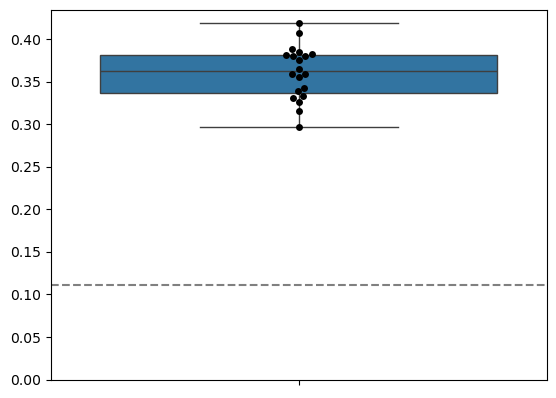

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
# from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
# plt.boxplot(iter_accs.mean(axis=1))
sns.boxplot(data=iter_accs.mean(axis=1))
sns.swarmplot(data=iter_accs.mean(axis=1), color='black')
plt.axhline(y=1/9, color='gray', linestyle='--')
plt.ylim(0, None)
plt.show()

In [14]:

np.mean(fold_accs)

0.20790043